In [ ]:
#@title
#run a snn on simple dataset
!git clone https://github.com/stefaniaebli/simplicial_neural_networks.git
# %cd simplicial_neural_networks
!pip install PyGSP

Cloning into 'simplicial_neural_networks'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 339 (delta 50), reused 48 (delta 48), pack-reused 280
Receiving objects: 100% (339/339), 2.42 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.2 MB/s eta 0:00:00


In [ ]:
# CONDA_CHANNEL_PRIORITY=flexible conda env create -f environment.yml
# conda activate snn

In [ ]:
!pip install gudhi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.6 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/epfl-lts2/pygsp

Cloning into 'pygsp'...
remote: Enumerating objects: 13136, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 13136 (delta 43), reused 49 (delta 23), pack-reused 13030
Receiving objects: 100% (13136/13136), 4.43 MiB | 9.13 MiB/s, done.
Resolving deltas: 100% (10190/10190), done.


In [ ]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib as mpl
from matplotlib import pyplot as plt
import gudhi
import pygsp as pg

import sys
# sys.path.append('..')
from simplicial_neural_networks.data.s2_6_complex_to_laplacians import build_boundaries, build_laplacians

**bold text**## 1 Build an alpha complex from a point cloud

The simplicial complex is built from a [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).
See the [CGAL documentation](https://doc.cgal.org/latest/Triangulation/index.html).

Alternatives:
* [`scipy.spatial.Delaunay`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html).
  Only for convex shapes?
* Directly use CGAL. There are Python bindings, but [they don't seem to include the Delaunay triangulation](https://github.com/CGAL/cgal-swig-bindings/wiki/Package_wrappers_available).

100 points


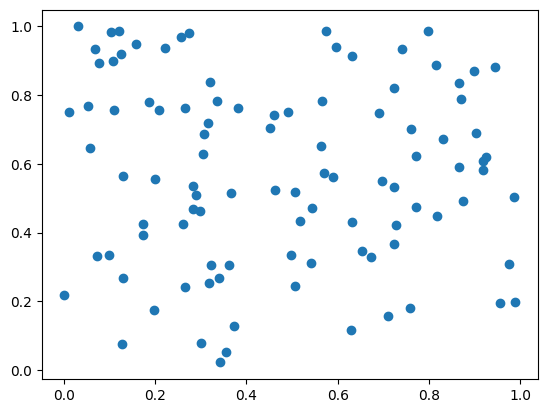

In [ ]:
n_points = 100  # Approximate.
dim = 2

rs = np.random.RandomState(None)
points = np.concatenate([
    [0.2, 1] * rs.uniform(size=(n_points//4, dim)),
    [0.2, 0.8] + [0.6, 0.2] * rs.uniform(size=(n_points//6, dim)),
    [0.2, 0] + [0.6, 0.2] * rs.uniform(size=(n_points//6, dim)),
    [0.8, 0] + [0.2, 1] * rs.uniform(size=(n_points//4, dim)),
    [0.4, 0.4] + [0.2, 0.2] * rs.uniform(size=(n_points//6, dim))
])

points = np.random.uniform(size=(n_points, dim))
#points = pg.graphs.Grid2d(10).coords

n_points = points.shape[0]
print(f'{n_points} points')

plt.scatter(*points.T);

189 triangles


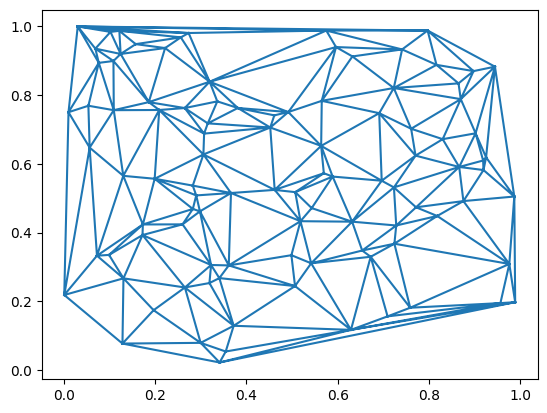

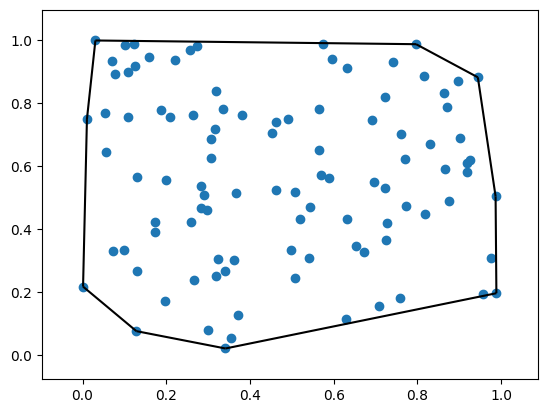

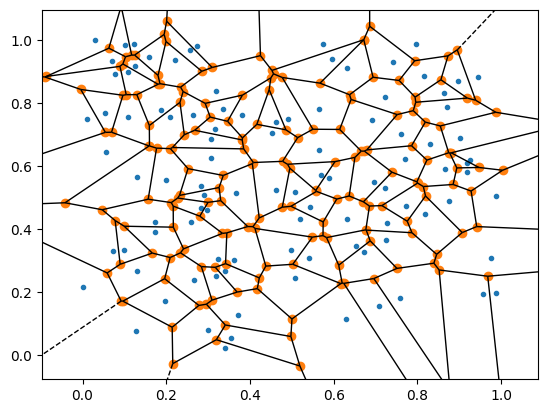

In [ ]:
from scipy import spatial
from scipy.spatial import convex_hull_plot_2d,voronoi_plot_2d

tri = spatial.Delaunay(points)
hull = spatial.ConvexHull(points)
voro = spatial.Voronoi(points)
print(f'{tri.simplices.shape[0]} triangles')

plt.triplot(points[:,0], points[:,1], tri.simplices);
plt.show(convex_hull_plot_2d(hull))
plt.show(voronoi_plot_2d(voro))

In [ ]:
ac = gudhi.AlphaComplex(points)
st = ac.create_simplex_tree()

before = st.num_simplices()
_ = st.prune_above_filtration(1e-2)
print(f'filtration: {before} => {st.num_simplices()} simplices')

assert st.num_vertices() == n_points
assert st.dimension() == dim

filtration: 577 => 482 simplices


## 2 Extract simplices

* $n_0$ is the number of 0-simplices (nodes)
* $n_1$ is the number of 1-simplices (edges)
* $n_2$ is the number of 2-simplices (triangles)
* $n_k$ is the number of $k$-simplices

`simplices` is a list of dictionaries, with one dictionary per degree $k$.
Each dictionary maps a simplex (represented as a set of vertices) to an integer that will be its index in the boundary and Laplacian operators.

In [ ]:
def extract_simplices(simplex_tree):
    simplices = [dict() for _ in range(simplex_tree.dimension()+1)]
    for simplex, _ in simplex_tree.get_skeleton(simplex_tree.dimension()):
        k = len(simplex)
        simplices[k-1][frozenset(simplex)] = len(simplices[k-1])
    return simplices
simplices = extract_simplices(st)


In [ ]:
for k, s in enumerate(simplices):
    print(k,len(s))

0 100
1 244
2 138


In [ ]:
for k, s in enumerate(simplices):
    print(f'n_{k} = {len(s):,} {k}-simplices')

n_0 = 100 0-simplices
n_1 = 244 1-simplices
n_2 = 138 2-simplices


## 2.1 Plotting

In [ ]:
def get_positions(simplices, dim):
    polygons = list()
    for i, simplex in enumerate(simplices[dim].keys()):
        assert simplices[dim][simplex] == i  # Dictionary is ordered.
        polygon = list()
        for vertex in simplex:
            polygon.append(points[vertex])
        polygons.append(polygon)
    return polygons

lines = get_positions(simplices, 1)
triangles = get_positions(simplices, 2)

In [ ]:
def value2color(values):
    values -= values.min()
    values /= values.max()
    return mpl.cm.viridis(values)

def plot_nodes(colors, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(points[:, 0], points[:, 1], c=colors, **kwargs)
    return ax.figure, ax

def plot_edges(colors, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subfigs()
    colors = value2color(colors)
    collection = mpl.collections.LineCollection(lines, colors=colors, **kwargs)
    ax.add_collection(collection)
    ax.autoscale()

def plot_triangles(colors, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subfigs()
    colors = value2color(colors)
    for triangle, color in zip(triangles, colors):
        triangle = plt.Polygon(triangle, color=color, **kwargs)
        ax.add_patch(triangle)
    ax.autoscale()
    
def plot_triangles_plain( ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subfigs()
    colors = len(simplices[1])*['linen']
    for triangle, color in zip(triangles, colors):
        triangle = plt.Polygon(triangle, color=color, **kwargs)
        ax.add_patch(triangle)
    ax.autoscale()

## 3 Build boundary operators

$$
\nabla_k \in \mathbb{R}^{n_{k-1} \times n_k}, \ k \in [1, K]
$$

* Also known as incidence matrices.
* Each $k$-simplex is connected to its $(k-1)$-faces.
* They are the gradient operators (and their transpose are the divergence operators).

In [ ]:
boundaries = build_boundaries(simplices)

### 3.1 Discrete derivatives and integrals

* $\nabla_k^\top \in \mathbb{R}^{n_k \times n_{k-1}}$ is the difference operator (discrete exterior derivative)
* $\langle \nabla_k^\top f, g \rangle = (\nabla_k^\top f)^\top g = f^\top \nabla_k g = \langle f, \nabla_k g \rangle$, hence $\nabla_k$ is the codifferential of $\nabla_k^\top$.
  The codifferential is the adjoint of the difference.
* The codifferential represents sums ("finite integrals") over $k$-surfaces.

In [ ]:
print(boundaries[0].shape)
print(boundaries[1].shape)


(100, 244)
(244, 138)


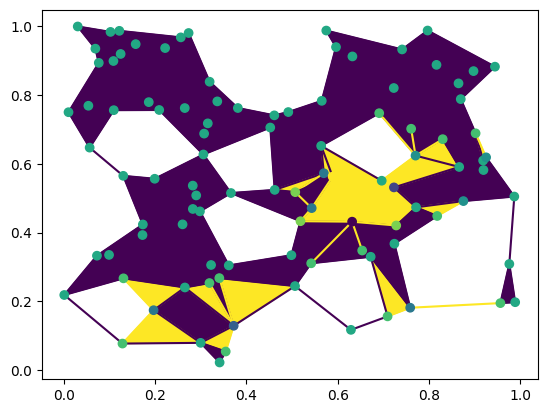

In [ ]:
s1 = np.zeros(len(simplices[1]))
s1[120:150] = 1

#s1 = np.random.uniform(size=len(simplices[1]))

s0 = boundaries[0] @ s1 # the operator @ multiplies matrixes
s2 = boundaries[1].T @ s1

fig, ax = plt.subplots()
plot_nodes(s0, ax, zorder=3)
plot_edges(s1, ax, zorder=2)
plot_triangles(s2, ax, zorder=1)

#plt.colorbar(ax.collections[0], ax=ax)

## 4 Build Laplacians

$$
L_k = L_k^\text{down} + L_k^\text{up}
    = \nabla_{k}^\top \nabla_{k} + \nabla_{k+1} \nabla_{k+1}^\top
    \in \mathbb{R}^{n_k \times n_k}, \ k \in [0, K]
$$

* Graph Laplacian $L_0 = \nabla_{1} \nabla_{1}^\top$
* Last Laplacian $L_K = \nabla_{K}^\top \nabla_{K}$

In [ ]:
laplacians = build_laplacians(boundaries)

In [ ]:
for k, laplacian in enumerate(laplacians):
  print(laplacian.shape)

(100, 100)
(244, 244)
(138, 138)


In [ ]:
for k, laplacian in enumerate(laplacians):
    print('{}-simplices: {:,} simplices, {:.2%} sparse'.format(k, laplacian.shape[0], laplacian.nnz/np.prod(laplacian.shape)))
    assert laplacian.shape == (len(simplices[k]), len(simplices[k]))

0-simplices: 100 simplices, 5.88% sparse
1-simplices: 244 simplices, 2.56% sparse
2-simplices: 138 simplices, 2.57% sparse


## 5 Eigenvectors

$$
L_k = V_k \Lambda_k V_k^\top, \ V_k = [v_1, \dots, v_{n_k}] \in \mathbb{R}^{n_k \times n_k}
$$

### 5.1 Vertices (0-simplices)

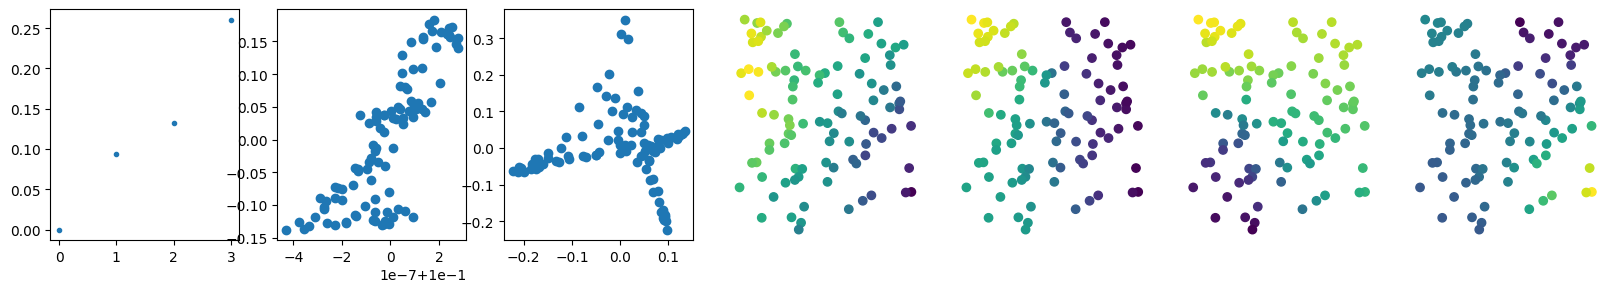

In [ ]:
def plot_eigen(laplacian, plot, n_eigenvectors=4):
    values, vectors = sparse.linalg.eigsh(laplacian, n_eigenvectors, which='SM')
    fix, axes = plt.subplots(1, n_eigenvectors+3, figsize=(20, 3))
    axes[0].plot(values, '.')
    axes[1].scatter(vectors[:, 0], vectors[:, 1])
    axes[2].scatter(vectors[:, 2], vectors[:, 3])
    for i in range(n_eigenvectors):
        plot(vectors[:, i], axes[i+3])
        axes[i+3].axis('off')

plot_eigen(laplacians[0], plot_nodes)

### 5.2 Edges (1-simplices)

The edges indeed seem to be embeded in linear subspaces.

TODO:
* Why don't the edge eigenvectors concentrate around the hole?
  As in [Control Using Higher Order Laplacians in Network Topologies](https://pdfs.semanticscholar.org/b3e5/5866a7463295f52962db66f26eaa348bd935.pdf), figure 4.

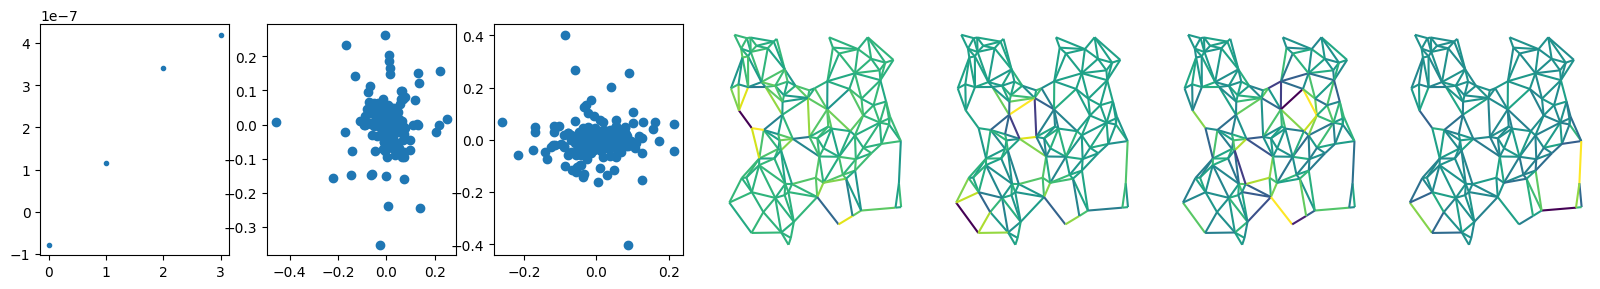

In [ ]:
plot_eigen(laplacians[1], plot_edges)

### 5.3 Triangles (2-simplices)

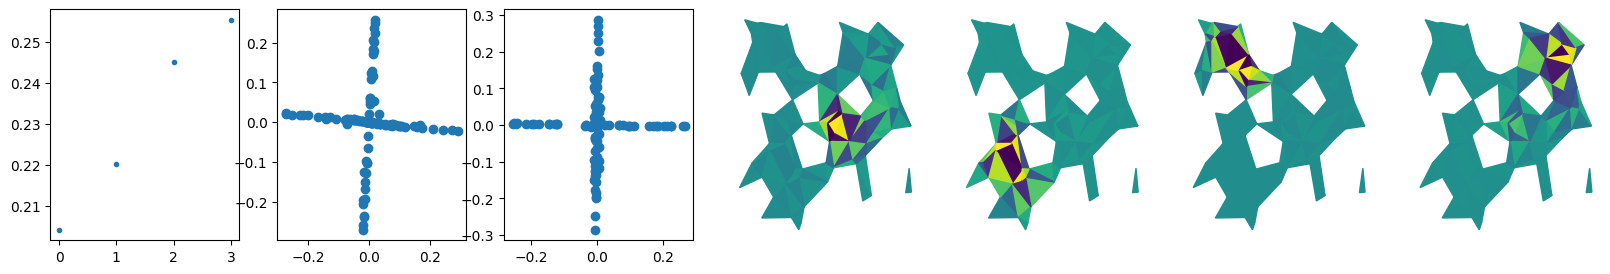

In [ ]:
plot_eigen(laplacians[2], plot_triangles)

## 5.4 Heat diffusion

We study the following dynamical system.

$$\frac{\partial s(t)}{\partial t}=-L_k s(t)$$

In [ ]:
values, vectors = [], []
for j , laplacian in enumerate(laplacians):
    w, v = np.linalg.eigh(laplacians[j].toarray())
    values.append(w)
    vectors.append(v)

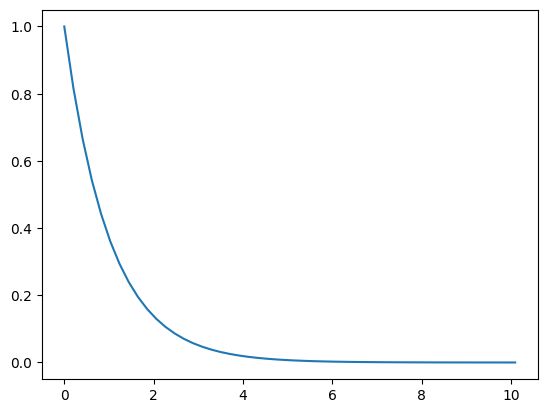

In [ ]:
class Heat:

    def __init__(self, t, lmax):
        self.t = t
        self.lmax = lmax

    def __call__(self, x):
        return np.exp(-self.t * x / self.lmax)

    def plot(self):
        x = np.linspace(0, self.lmax)
        plt.plot(x, self(x))
dim=0
heat = Heat(t=10, lmax=values[dim][-1])
heat.plot()

(100,)
20.000000600547754


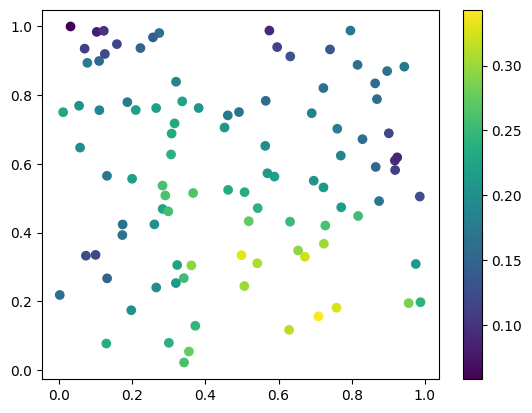

In [ ]:
s = np.zeros(len(simplices[0]))
s[50:70] = 1

#s = np.random.uniform(size=len(simplices[0]))

def filter(d, signal):
    return vectors[d] @ (heat(values[d]) * (vectors[d].T @ signal))

s = filter(0, s)
print(s.shape)

fig, ax = plot_nodes(s)
plt.colorbar(ax.collections[0], ax=ax)
#plot_edges(np.zeros(len(simplices[1])), ax=ax, zorder=0)

print(np.linalg.norm(s, 1))

### Heat diffusion on 1-simplices using the 1-Laplacian

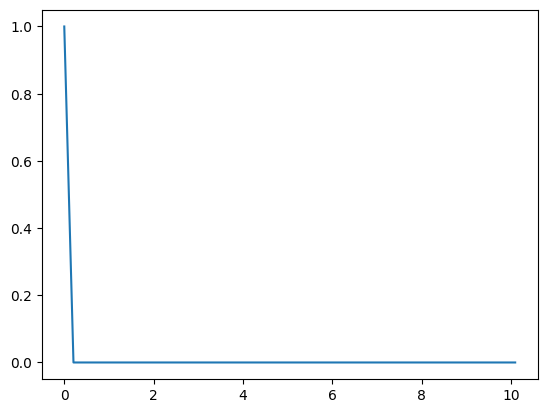

In [ ]:
dim=1
iterations=1000
heat = Heat(t=iterations, lmax=values[dim][-1])
heat.plot()

(244,)
123.34749696795836


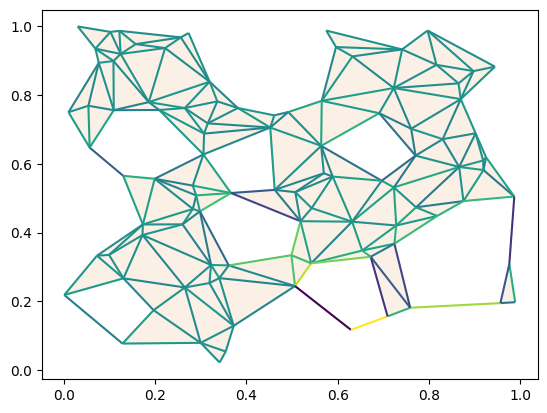

In [ ]:
s = np.zeros(len(simplices[dim]))
#s[100:150] =1
s = np.random.uniform(size=len(simplices[dim]))
init_cond=np.copy(s)
def filter(d, signal):
    return vectors[d] @ (heat(values[d]) * (vectors[d].T @ signal))

s = filter(dim, s)
filtred_s=np.copy(s)
print(s.shape)
fig, ax = plt.subplots()
plot_edges(s, ax, zorder=2) #norm=False,
plot_triangles_plain(ax, zorder=1)
#plt.colorbar(ax.collections[0], ax=ax)
print(np.linalg.norm(s, 1))

### Convergence of the dynamical system.

As studied in [Control Using Higher Order Laplacians in Network Topologies](https://pdfs.semanticscholar.org/b3e5/5866a7463295f52962db66f26eaa348bd935.pdf), Chapter IV.
 - In case $H_1=0$ the dynamical system converges to 0.
 - In case $H_1\neq 0$ the dynamical system converges to some point in $ker(L_1)$

In [ ]:
if np.isclose(values[1][0],10**-10):
    epsilon=0.0001
    harm_dist=np.linalg.norm(vectors[1][0]-filtred_s, 2)
    c=~np.isclose(values[1],10**-8)
    t_epsilon=-1/values[1][c][0]*np.log(epsilon/(np.linalg.norm(init_cond, 2)*len(init_cond)))
    print('The solution is epsilon-harmonic for all t > {}'.format(t_epsilon))
    print('After {} iterations the distance from one harmonic representative is {}'.format(iterations,harm_dist))
else:
    print('The solution converges to zero. After {} iterations the norm is {}'.format(iterations,np.linalg.norm(filtred_s, 2)))


The solution is epsilon-harmonic for all t > 179.6681316052983
After 1000 iterations the distance from one harmonic representative is 1.6366965995110012


2023-05-31 20:28:55,814:[WARNING](pygsp.graphs.graph._check_fourier_properties): The eigenvalues vector G.e is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


19.999999999999982


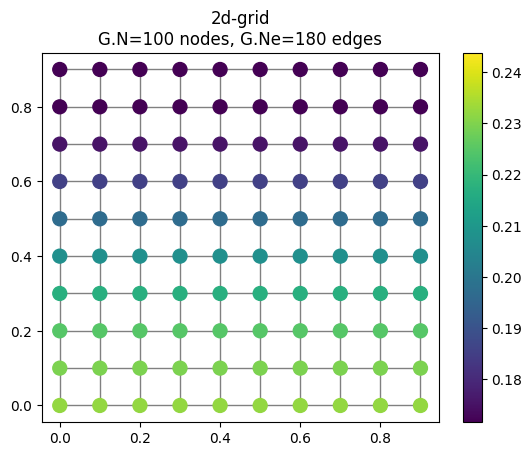

In [ ]:
# from pygsp import graphs
# import pygsp as pg
graph = pg.graphs.Grid2d(10)
g = pg.filters.Heat(graph, 100)
s = np.zeros(graph.N)
s[50:70] = 1
s = g.filter(s, method='exact')
graph.plot_signal(s)
print(np.linalg.norm(s, 1))

## 6 Test

Simplicial complex and ground truths from [Control Using Higher Order Laplacians in Network Topologies](https://pdfs.semanticscholar.org/b3e5/5866a7463295f52962db66f26eaa348bd935.pdf), figure 3.

[[-0.46949297 -0.40066028]
 [ 0.46949303  0.4006604 ]
 [-0.42593908 -0.09514251]
 [-0.04355389 -0.3055178 ]
 [ 0.38238513 -0.21037531]
 [-0.33883128  0.51589316]
 [ 0.3388312  -0.5158933 ]]


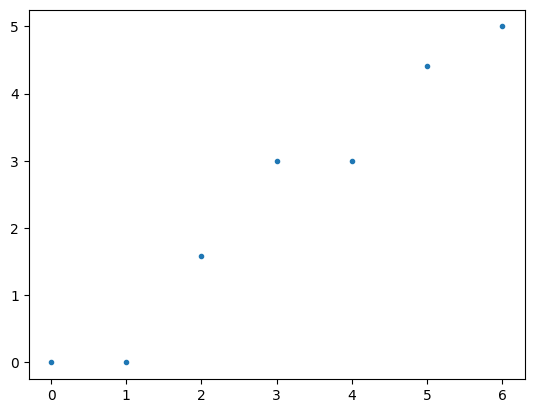

In [ ]:
simplices = [
    {
        frozenset([0]): 0,
        frozenset([1]): 1,
        frozenset([2]): 2,
        frozenset([3]): 3,
        frozenset([4]): 4,
    },
    {
        frozenset([0, 1]): 0,
        frozenset([0, 2]): 1,
        frozenset([1, 2]): 2,
        frozenset([1, 3]): 3,
        frozenset([2, 3]): 4,
        frozenset([2, 4]): 5,
        frozenset([3, 4]): 6,
    },
    {
        frozenset([1, 2, 3]): 0,
    },
]

boundaries = build_boundaries(simplices)
laplacians = build_laplacians(boundaries)

_, vectors = sparse.linalg.eigsh(laplacians[1], 2, which='SM')
print(vectors)

values, vectors = np.linalg.eigh(laplacians[1].toarray())
plt.plot(values, '.');